# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday October the 31st, 2021 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/


(If you haven't set up an account on peergrade yet, go to www.peergrade.io/join and type in the class code: ***DPZEV6***.)

### Overview

This year's Assignment 2 is all about analyzing the network of rappers.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

# Part 0: Building the network 

To create our network, we downloaded the rapper Wiki pages from each coast (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions.

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.
> * Show the regular expressions you have built and explain in details how they work.

## Answer to Part 0

#### Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.

>To extract all of the hyperlinks from the rappers' wiki-pages we used Wikipedias own API and Regex to detect and extract all the hyperlinks.
>
>1. With a dataframe of their Wikipedia page name we can call the Wikipedia API in a loop though all the WikipediaPageNames. By having the following props:
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": rapper
    }
>
>The Wikipedia API allow us to get the wikipedia pages in a text format, where hyperlinks are in the form: [[hyperlink|name of hyperlink]].
>
>2. Once we have gotten the wikipedia page in the desired format we use the regex pattern and find all the hyperlinks with the pattern, r'\[{2}(.+?)\]{2}'
>
>3. To determine if the hyperlink is relevant or not, i.e it links to a rappers wikipedia page, we check if the name of the hyperlink can be found in out dataframe with wikipedia page names.
>
>Below you can see the loop where the outlined steps are performed.

    for i, rapper in enumerate(df['WikipediaPageName']):
        print(i, rapper)

        params = {
            "action": "query",
            "prop": "revisions",
            "rvprop": "content",
            "format": "json",
            "titles": rapper
        }
        
        wikitext = requests.get(baseurl, params=params)
        wikijson = wikitext.json()
        key = wikijson['query']['pages'].keys()
        text = wikijson['query']['pages'][str(list(key)[0])]['revisions'][0]['*']
        
        match = re.findall(pattern, text)

        for string in match:
            wikilink = string.split('|')[0]
            if (wikilink in df['WikipediaPageName'].values):
                di_G.add_edge(rapper, wikilink)

#### Show the regular expressions you have built and explain in details how they work.

>Our Regex pattern is:
>r'\[{2}(.+?)\]{2}'
>
>r is just for designating a python raw string, so it can pass through backslashes without changing the string. \
>
>\\[{2} means two opening square brackets, [[
>
>(.+?). Here the . means any character and the + means 1 or more making the search "greedy. So now every character onwards will be included. Then there is ?, which means 0 or 1 of the previous expression, making it non greedy. This means it will stop at the next part of the pattern, which is the two closing sqaure bracket.
>
>\\]{2} means two opening square brackets, ]]

In [63]:
import pandas as pd
import networkx as nx
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import nltk
import requests
import community

from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize
from nltk import FreqDist
from wordcloud import WordCloud, STOPWORDS

In [64]:
if os.path.exists("files/rappers_undirected.gexf") and os.path.exists("files/rappers_west.gexf") and os.path.exists("files/rappers_east.gexf"):
    df = pd.read_csv("files/rappers.csv")
    di_G = nx.read_gexf("files/rappers_giant_component.gexf")
    di_G_west = nx.read_gexf("files/rappers_west.gexf")
    di_G_east = nx.read_gexf("files/rappers_east.gexf")
    G = di_G.to_undirected()
    G_west = di_G_west.to_undirected()
    G_east = di_G_east.to_undirected()
    print("Graph loaded from file")
else:
    df = pd.read_csv("files/rappers.csv")
    df_west = pd.read_csv("files/WestCoastRappers.csv",index_col=0)
    df_east = pd.read_csv("files/EastCoastRappers.csv",index_col=0)

    df_west['Coast'] = 'West'
    df_east['Coast'] = 'East'

    df = pd.concat([df_west, df_east], ignore_index=True)

    di_G = nx.DiGraph()

    for i in df.index:
        di_G.add_node(df['WikipediaPageName'][i], coast=df['Coast'][i])
    
    baseurl = "https://en.wikipedia.org/w/api.php?"

    pattern = r'\[{2}(.+?)\]{2}'
    word_pattern = r'\b\w+\b'

    for i, rapper in enumerate(df['WikipediaPageName']):
        print(i, rapper)

        params = {
            "action": "query",
            "prop": "revisions",
            "rvprop": "content",
            "format": "json",
            "titles": rapper
        }
        wikitext = requests.get(baseurl, params=params)
        wikijson = wikitext.json()
        key = wikijson['query']['pages'].keys()
        text = wikijson['query']['pages'][str(list(key)[0])]['revisions'][0]['*']
        
        match = re.findall(pattern, text)

        for string in match:
            wikilink = string.split('|')[0]
            if (wikilink in df['WikipediaPageName'].values):
                di_G.add_edge(rapper, wikilink)
    
    di_G_connected = list(di_G.subgraph(c) for c in nx.weakly_connected_components(di_G))
    di_G_giant = di_G_connected[0]
    for subgraph in di_G_connected:
        if len(subgraph) > len(di_G_giant):
            di_G_giant = subgraph
    
    di_G = di_G_giant

    di_G_west = nx.DiGraph()
    for node in di_G.nodes():
        if di_G.nodes[node]['coast'] == 'West':
            di_G_west.add_node(node, coast='West')

    for edge in di_G.edges():
        if di_G.nodes[edge[0]]['coast'] == 'West' and di_G.nodes[edge[1]]['coast'] == 'West':
            di_G_west.add_edge(edge[0], edge[1])

    di_G_east = nx.DiGraph()
    for node in di_G.nodes():
        if di_G.nodes[node]['coast'] == 'East':
            di_G_east.add_node(node, coast='East')

    for edge in di_G.edges():
        if di_G.nodes[edge[0]]['coast'] == 'East' and di_G.nodes[edge[1]]['coast'] == 'East':
            di_G_east.add_edge(edge[0], edge[1])


    nx.write_gexf(di_G, "files/rappers_giant_component.gexf")
    nx.write_gexf(di_G_west, "files/rappers_west.gexf")
    nx.write_gexf(di_G_east, "files/rappers_east.gexf")
        

Graph loaded from file


## Answer to Part 1

# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network? 
> * What is the number of links?
> * Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> * Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 
> * Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?
> * Plot the in- and out-degree distributions for the whole network. 
>   * Use axes that make sense for visualizing this particular distribution.
>   * What do you observe? 
>   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?
> * Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. What useful information can you decipher from this?

## Answer to Part 1

In [65]:
print(di_G)

DiGraph with 728 nodes and 5809 edges


#### What is the number of nodes in the network? 
>There are 728 nodes in the graph

#### What is the number of links?
>There are 5809 edges in the graph

#### Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [66]:
most_conected_in = sorted((di_G.in_degree), key=lambda x: x[1], reverse=True)[0]
most_conected_out = sorted((di_G.out_degree), key=lambda x: x[1], reverse=True)[0]
print(most_conected_in)
print(most_conected_out)

('Snoop Dogg', 127)
('Drag-On', 52)


>Snoop Dogg is the most connected rapper with regard to in-degrees. \
>Drag-On is the most connected rapper with regard to out out-degrees.
>
>The findings are what can be expected. Since Snoop Dogg is a big name in the rapper industry, making it a big achievement for most rappers to be affiliated with him, which merits a mention on their wikipedia page. Drag-On is the rapper with the highest out-degree, which is also expected since small to mid sizes names in the rap industry would probably mention every other rapper affiliation they have.

#### Who are the top 5 most connected east-coast and west-coast rappers (again in terms of in/out-degree)? 

In [103]:
east_dict = {}
west_dict = {}

for node, attributes in di_G.nodes(data=True):
    if attributes['coast'] == "East":
        east_dict[node] = {
            'in_degree': di_G.in_degree(node),
            'out_degree': di_G.out_degree(node),
            'coast': "East"
        }
    else:
        west_dict[node] = {
            'in_degree': di_G.in_degree(node),
            'out_degree': di_G.out_degree(node),
            'coast': "West"
        }

top5_in_east = dict(sorted(east_dict.items(), key=lambda x: x[1]['in_degree'], reverse=True)[:5])
top5_out_east = dict(sorted(east_dict.items(), key=lambda x: x[1]['out_degree'], reverse=True)[:5])
top5_in_west = dict(sorted(west_dict.items(), key=lambda x: x[1]['in_degree'], reverse=True)[:5])
top5_out_west = dict(sorted(west_dict.items(), key=lambda x: x[1]['out_degree'], reverse=True)[:5])


print("Top 5 East Coast (int-degree)")
for i, r in enumerate(top5_in_east):
    print(r, top5_in_east[r]['in_degree'])
    
print("\nTop 5 East Coast (out-degree)")
for i, r in enumerate(top5_out_east):
    print(r, top5_out_east[r]['out_degree'])
    
print("\nTop 5 West Coast (in-degree)")
for i, r in enumerate(top5_in_west):
    print(r, top5_in_west[r]['in_degree'])
    
print("\nTop 5 West Coast (out-degree)")
for i, r in enumerate(top5_out_west):
    print(r, top5_out_west[r]['out_degree'])


Top 5 East Coast (int-degree)
Jay-Z 114
Nas 98
50 Cent 91
Busta Rhymes 82
The Notorious B.I.G. 63

Top 5 East Coast (out-degree)
Drag-On 52
Black Thought 42
Jahlil Beats 35
MC Lyte 35
Uncle Murda 34

Top 5 West Coast (in-degree)
Snoop Dogg 127
Dr. Dre 81
Kendrick Lamar 75
Tupac Shakur 70
E-40 60

Top 5 West Coast (out-degree)
DJ Dahi 38
Dr. Dre 36
The Game (rapper) 36
Kendrick Lamar 36
Kurupt 35


>The top 5 most connected east rappers with regards to in-degrees are:
>   1. Jay-Z
>   2. Nas
>   3. 50 Cent
>   4. Busta Rhymes
>   5. The Notorious B.I.G.

>The top 5 most connected east rappers with regards to out-degrees are:
>   1. Drag-On
>   2. Black Thought
>   3. Jahlil Beats
>   4. MC Lyte
>   5. Uncle Murda

>The top 5 most connected west rappers with regards to in-degrees are:
>   1. Snoop Dogg
>   2. Dr. Dre
>   3. Kendrick Lamar
>   4. Tupac Shakur
>   5. E-40

>The top 5 most connected west rappers with regards to out-degrees are:
>   1. DJ Dahi
>   2. Dr. Dre
>   3. The Game
>   4. Kendrick Lamar
>   5. Kurupt

#### Plot the in- and out-degree distributions for the whole network.

In [124]:
k_in = [di_G.in_degree(node) for node in di_G.nodes()]
k_out = [di_G.out_degree(node) for node in di_G.nodes()]
avg_k_in = np.mean(k_in)
avg_k_out = np.mean(k_out)
avg_k_in_sq = np.mean(np.square(k_in))
avg_k_out_sq = np.mean(np.square(k_out))
print("<k_in>", avg_k_in)
print("<k_out>", avg_k_out)

print("<k_in^2>", avg_k_in_sq)
print("<k_out^2>", avg_k_out_sq)

<k_in> 7.979395604395604
<k_out> 7.979395604395604
<k_in^2> 250.94642857142858
<k_out^2> 120.45467032967034


min out-degree: 0
max out-degree: 52


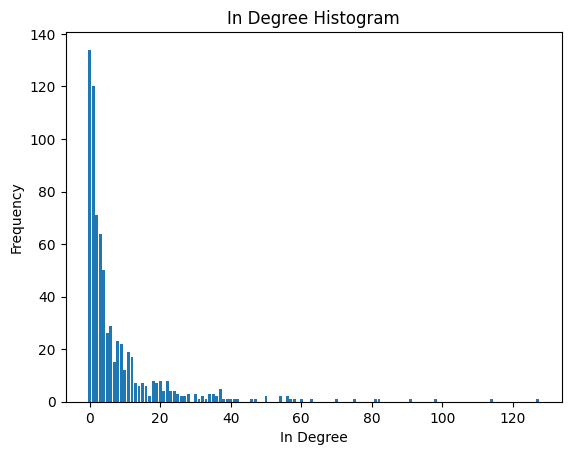

In [108]:
k_in = [d for n, d in di_G.in_degree()] 
max_k_in = np.max(k_in)
min_k_in = np.min(k_in)
print(f'min out-degree: {min_k_out}')
print(f'max out-degree: {max_k_out}')
v = np.arange(min_k_in,max_k_in+2)

counts_in, bins_in = np.histogram(k_in, bins=v)
sum_counts_in = np.sum(counts_in)
plt.bar(bins_in[:-1], counts_in)

plt.title("In Degree Histogram")
plt.ylabel("Frequency")
plt.xlabel("In Degree")
plt.show()

min out-degree: 0
max out-degree: 52


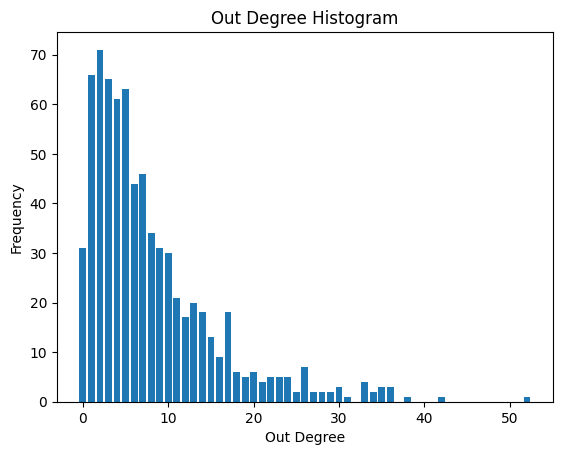

In [113]:
k_out = [d for n, d in di_G.out_degree()]
max_k_out = max(k_out)
min_k_out = min(k_out)
print(f'min out-degree: {min_k_out}')
print(f'max out-degree: {max_k_out}')
v = np.arange(min_k_out, max_k_out+2)

counts_out, bins_out = np.histogram(k_out, bins=v)
sum_counts_out = np.sum(counts_out)

plt.bar(bins_out[:-1], counts_out)
plt.title("Out Degree Histogram")
plt.xlabel("Out Degree")
plt.ylabel("Frequency")
plt.show()

##### What do you observe? 

>We see that the in-degrees are very low with the most common being 0, while the out-degrees most common value is a little higher.
>
>Both in and out degree distributions follow a Powerlaw distribution since they have fat-tails. Here $\langle k^2\rangle$, also called the second mode which describes the variance of the degree, is much larger than the average degree $\langle k\rangle$, meaning outlier nodes with a very high degree are expected. This is especially evident in the case of the in-degree. In this network $\langle k_{in}^2\rangle = 250.9$, $\langle k_{out}^2\rangle=120.4$ and $\langle k_{in}\rangle = \langle k_{out}\rangle = 7.98$.  
>
>The vast majority of both in and out degrees are between 0 and 8, which is between 0 and the average degree. And the max for in-degrees is 127 and for out-degrees it is 52.

#### Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
>Every edge has two nodes, one where the egde is out-going and one where the degree is incoming. This means there is a 1-to-1 relationship between the in-degrees and out-degrees. If the network increases in size, there is a chance that 1 node has a lot of outgoing edge to many different nodes, or in some other cases the same node has a lot of incoming edges from man different nodes. The 1-to-1 relationship therefore diminished and the in- and out-going degree distributions will start to look very different. 

*Interpretation*
>The reason why the in- and out-degrees look different is because real networks are expected to develop hubs. For the rapper wikipedia pages the hubs might be caused by very influential individuals where these influential individuals will have a lot of in-degrees. The opposite is case for very non-influential individuals who might be new or have a limited career. These individuals are a lot more common which is why there are so many nodes with low or no in-degrees. 
>
>Fame in the rapper world is also easier achieved when you have contacts or were "discovered" by someone who is already influential. Therefore, some of the rappers fame should be attributed to atleast a few other rapper, not every other rapper, which is why there are a lot more rappers with an out-degree of 1 than there are rappers with out-degree 0. It can also be seen that the amount of rappers with a high out degree are more common than rappers with a high in-degree. 
>
>This explains why the max value for in-degrees are 127 and why the max value for out degrees is much lower at 52. But there of course a lot of other factors too, like have active the artist is, how many other artists the rapper has collaborated with, but this is one explanation.

#### Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?

In [71]:
# Powerlaw
alpha_in = powerlaw.Fit(k_in).alpha
alpha_out = powerlaw.Fit(k_out).alpha

print(f'alpha in: {alpha_in}')
print(f'alpha out: {alpha_out}')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
alpha in: 2.728424664021232
alpha out: 12.24236893689206


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


>In degree exponent: 2.728 \
>Out degree exponent: 12.242

>The degree exponent for the in- and out-degrees are very different from each other. 
>
>The degree exponent for in-degrees is between 2 and 3 and its therefore in the Ultra-Small World regime. Here, there is a balance between local and global connectivity. Most nodes have a small in-degree, but there should be some with a significant number of nodes with higher in-degrees.
>
>The degree exponent for out-degrees is a lot greater than 3 which means it's in the small World regime. In this regime, the majority of nodes have limited outgoing connections, and only a select few nodes have a significantly higher number of outgoing connections. Here a small number of nodes are key influencers, which fits well in the rapper industry, as some rappers might be producers too.
>
>These traits can also be seen in the in- and out-degree histrograms.

#### Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

In [72]:
p = avg_k/(N-1)
print("p", p)
G_ER = nx.erdos_renyi_graph(N, p, directed=False)

p 0.02195156975074444


In [73]:
print("lnN", np.log(N))
print("lnN/N", np.log(N)/N)

lnN 6.590301048196686
lnN/N 0.009052611329940502


>The Erdos Renyi graph has 728 nodes with 5809 links and p $\approx$ 0.022

28
7
728


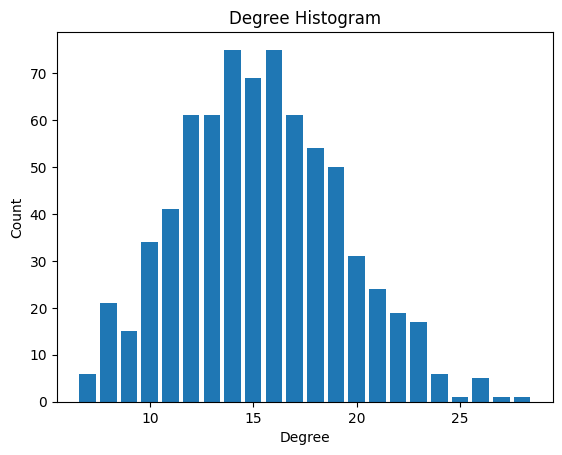

In [74]:
k_ER = [d for n, d in G_ER.degree()] 
max_k_ER = np.max(k_ER)
min_k_ER = np.min(k_ER)
print(max_k_ER)
print(min_k_ER)
v_ER = np.arange(min_k_ER,max_k_ER+2)

counts_ER, bins_ER = np.histogram(k_ER, bins=v_ER)
sum_counts_ER = np.sum(counts_ER)
print(sum_counts_ER)

plt.bar(bins_ER[:-1], counts_ER)

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

>The degree distribution for the random network resemble a normal distribution, where it peaks at around 16, which is also where the average degree of the network approximately lie. 
>
>A normally distributed degree distribution also yields an absence of hubs in the network. This can also be seen in the degree distribution, as there are no node with a *significantly* higher degree than the rest of the nodes, with the highest degree being only 27. 
>
>The network is in the connected regime, as $<k>$ > lnN and p > LnN/N, meaning, not only is there a giant connected component but the it has also absorbed every single node of the network. This is probably true, considering the lowest degree in the random network is 5.

#### Create a nice visualization of the total (directed) network:

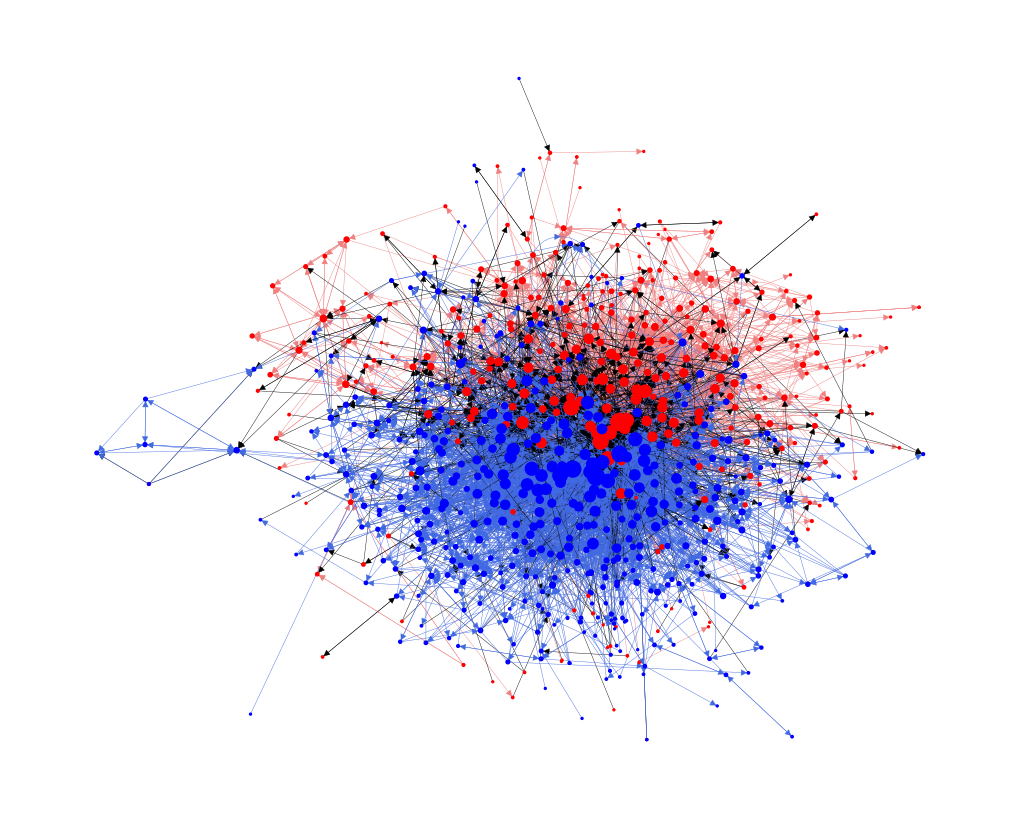

In [75]:
colors = ['red' if di_G.nodes[node]['coast']=='West' else 'blue' for node in di_G]
node_sizes = [di_G.degree(node)+1 for node in di_G]
edge_colors = []

for edge in di_G.edges():
    if di_G.nodes[edge[0]]['coast']=='West' and di_G.nodes[edge[1]]['coast']=='West':
        edge_colors.append('lightcoral')
    elif di_G.nodes[edge[0]]['coast']=='East' and di_G.nodes[edge[1]]['coast']=='East':
        edge_colors.append('royalblue')
    else:
        edge_colors.append('black')

plt.figure(figsize=(10, 8))
nx.draw_kamada_kawai(di_G, node_size=node_sizes, node_color=colors, edge_color=edge_colors, width=0.3, with_labels=False)
plt.show()

#### Describe the structure you observe. What useful information can you decipher from this?

>The graph looks like a very large cloud of nodes but using the kamadai_kawai method to draw the graph gives a better positioning of the nodes since connected nodes are closer to each other
>
>In the upper half of the graph most of the west coast rappers are and the lower half is where most of the east coast rappers are. Since the position of the nodes have been optimized by the kamadai_kawai drawing, it suggests that the rappers generally are more connected to rappers from the same coast as themselves. 
>
>In the middle are the biggest nodes, which are the most connected ones. Due to their position and the fact that a lot of their edges are black means that the the hubs from both coasts are typically highly cross-coast connected in addition to native-coast connected.

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
> * Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.
> * For each coast, what are the 5 words with the highest TR scores? Comment on your result.

## Answer to Part 2

#### Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.


>First, we need to create a text file for each coast that combines all the raw text files from each rapper in the coast. 

In [76]:
west_file_list = []
east_file_list = []
for i, (rapper, coast) in enumerate(zip(df["WikipediaPageName"],df["Coast"])):
    # save text to file
    file_name = rapper + '.txt'
    file_name = file_name.replace('-', '_')
    file_name = file_name.replace(' ', '_')
    file_name = file_name.replace('?', '')
    if coast == "West":
        west_file_list.append(file_name)
    else:
        east_file_list.append(file_name)

corpus_root = 'rapper_texts'

west_corpus = PlaintextCorpusReader(corpus_root, west_file_list)

east_corpus = PlaintextCorpusReader(corpus_root, east_file_list)

west_raw = west_corpus.raw()
east_raw = east_corpus.raw()


>The below method, get_TFTR, is defined to calculate the TR-TF using the TR-TF formular for each word in both coasts.
>
> $w_t^{(w)}=\frac{TF_t^{(w)}}{TF_t^{(e)}+c}$ and $w_t^{(e)}=\frac{TF_t^{(e)}}{TF_t^{(t)}+c}$
>
>The method takes three arguments, text1, text2 and c, which means it can be used on every pair of texts.

In [77]:
def get_TFTR(text1, text2, c = 1):

    stopwords = nltk.corpus.stopwords.words('english')

    text1_tokens = word_tokenize(text1)
    text1_words = [w.lower() for w in text1_tokens if (w.lower().isalpha() and w.lower() not in stopwords)]
    fdist1 = FreqDist(text1_words)

    text2_tokens = word_tokenize(text2)
    text2_words = [w.lower() for w in text2_tokens if (w.lower().isalpha() and w.lower() not in stopwords)]
    fdist2 = FreqDist(text2_words)

    dict1_TFTR = dict()
    dict2_TFTR = dict()

    for w in fdist1:
        if w in fdist2:
            weight1 = fdist1[w]/(fdist2[w]+c)
        else:
            weight1 = fdist1[w]/c
        dict1_TFTR[w] = weight1*fdist1[w]
        
    for w in fdist2:
        if w in fdist1:
            weight2 = fdist2[w]/(fdist1[w]+c)
        else:
            weight2 = fdist2[w]/c
        dict2_TFTR[w] = weight2*fdist2[w]

    dict1_TFTR = dict(sorted(dict1_TFTR.items(), key=lambda x:x[1], reverse=True))
    dict2_TFTR = dict(sorted(dict2_TFTR.items(), key=lambda x:x[1], reverse=True))

    return dict1_TFTR, dict2_TFTR


>Below get_TFTR is used on the raw text files for east and west coast, with c = 1

In [78]:
dict_west_TFTR, dict_east_TFTR = get_TFTR(west_raw, east_raw, c = 1)

west_str = ""
east_str = ""
for w in dict_west_TFTR:
    for i in range(int(dict_west_TFTR[w])):
        west_str += w + " "

for w in dict_east_TFTR:
    for i in range(int(dict_east_TFTR[w])):
        east_str += w + " "

>*Generating the wordclouds below*

>By default, WordCloud treats everything as collocations so this has to be turned off, by setting collocations = False. This will make WordCloud miss some real collocations like snoop dog and dr dre, but it will still make the wordcloud look a lot better. 

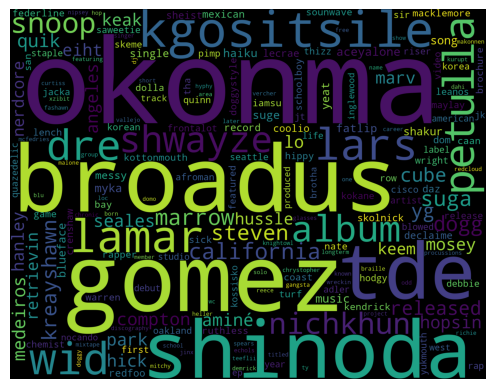

In [79]:
west_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(west_str)

plt.imshow(west_wordcloud)
plt.axis('off')
plt.show()

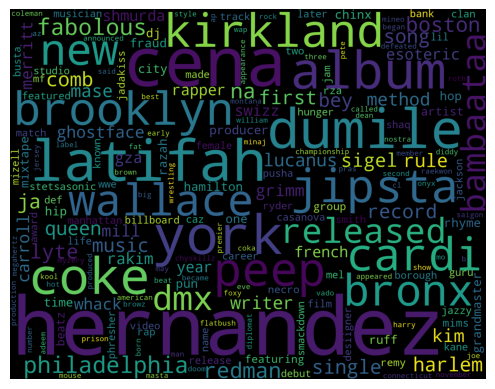

In [80]:
east_wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400,
                      collocations = False
                     ).generate(east_str)

plt.imshow(east_wordcloud)
plt.axis('off')
plt.show()

#### For each coast, what are the 5 words with the highest TR scores? Comment on your result.

In [97]:
print("Top 5 words in West Coast")
for i, w in enumerate(dict_west_TFTR):
    if i >= 5:
        break
    print(w, dict_west_TFTR[w])
    
        

print("\nTop 5 words in East Coast")
for i, w in enumerate(dict_east_TFTR):
    if i >= 5:
        break
    print(w, dict_east_TFTR[w])
    

Top 5 words in West Coast
okonma 10609.0
gomez 6400.0
broadus 6084.0
shinoda 4418.0
tde 4225.0

Top 5 words in East Coast
hernandez 20736.0
cena 14421.333333333332
latifah 9522.0
dumile 8836.0
york 8747.370078740158


>The top 5 words in the west coast wikipedia pages are:
>
>okonma: 10609.0\
>gomez: 6400.0\
>broadus: 6084.0\
>shinoda: 4418.0\
>tde: 4225.0
>

>The top 5 words in the east coast wikipedia pages are:
>
>hernandez: 20736\
>cena: 14421\
>latifah: 9522\
>dumile: 8836\
>york: 8747

# Part 3: Communities

Find communities and their modularity (from lecture 7).

Here's what you need to do:
> * In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 
> * Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?
> * Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.
> * Now, partition your rappers into two communities based on which coast they represent.
>   * What is the modularity of this partition? Comment on the result.

## Answer to Part 3

#### In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 

> The modularity of a community measures how well the community is connected to itself compared to the rest of the network. 
> $$ M_c = \frac{L_c}{L}-\left(\frac{k_c}{2L}\right)^2$$
> where $L_c$ is the number of edges within the community, $L$ is the total number of edges in the network, and $k_c$ is the total degree of the nodes in the community.
> The modularity of the network is the sum of the modularity of all the communities in the network.
> $$ M = \sum_{c=1}^{n_c} M_c$$
> where $n_c$ is the number of communities in the network.
> The higher the modularity, the better the partition of the network is.


#### Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?

> We find the communities in the network by using the Louvain heuristices, which tries to maximise the modularity by selecting the highest partition of the dendrogram generated by the Louvain algorithm.

In [82]:
partition = community.best_partition(G, random_state = 42)

#### Comment on your results:

##### How many communities did you find in total?

In [83]:
print(f'Number of communities: {len(set(partition.values()))}')

Number of communities: 8


> The algorithm found 8 communities.

##### Compute the value of modularity with the partition created by the algorithm.

In [84]:
M = community.modularity(partition, G)
print(M)

0.41677309091138653


> The modularity of the partition created by the algorithm is 0.417.

##### Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.

In [85]:
count_communities = dict(FreqDist(list(partition.values())))
count_communities = dict(sorted(count_communities.items(), key=lambda x:x[1], reverse=True))
print(count_communities)

{5: 173, 7: 161, 1: 152, 0: 138, 3: 48, 2: 37, 6: 12, 4: 7}


> We see that the communities are of very different sizes. The biggest community has 173 nodes while the smallest has only 7 nodes. 

#### Now, partition your rappers into two communities based on which coast they represent.

In [86]:
partition = {}
for node in G.nodes():
    if G.nodes[node]['coast'] == 'West':
        partition[node] = 0
    else:
        partition[node] = 1

##### What is the modularity of this partition? Comment on the result.

In [87]:
M = community.modularity(partition, G)
print(M)

0.24932094205717933


> The modularity of this partition is 0.249, which is lower than the modularity of the partition created by the Louvain algorithm. This is to be expected as the Louvain algorithm tries to find the partition with the highest modularity.

# Part 4: Sentiment of communities

Analyze the sentiment of communities (lecture 8). More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* Average the average sentiment of the nodes in each community to find a community-level sentiment.

Here's what you need to do (use the LabMT wordlist approach):
> * Calculate and store sentiment for every rapper
> * Create a histogram of all rappers' associated sentiments.
> * What are the 10 rappers with happiest and saddest pages?

Now, compute the sentiment of each coast: 
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).
> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.
> * Does the result make sense to you? Elaborate.

**Congratulations for making it to the end of the Assignment. Good luck with your independent project**



## Answer Part 4

#### Calculate and store sentiment for every rapper

> We start by loading all the rapper texts and the LabMT wordlist.

In [88]:
all_corpus = PlaintextCorpusReader('rapper_texts', '.*')
df_happiness = pd.read_csv('files/LabMT.txt', sep='\t')
dict_avg_happiness = {}
for i in range(len(df_happiness)):
    dict_avg_happiness[df_happiness['word'][i]] = df_happiness['happiness_average'][i]

> We then define a function to calculate the sentiments of a raw text given a dictionary of words and there corresponding average sentiment.

In [89]:
def get_sentiments(text, dict_avg):
    text_tokens = word_tokenize(text)
    text_words = [w.lower() for w in text_tokens if w.isalpha()]
    fdist = FreqDist(text_words)
    total_count = 0
    sentiment = 0
    for w in fdist:
        if w in dict_avg:
            sentiment += dict_avg[w]*fdist[w]
            total_count += fdist[w]
    if total_count == 0:
        return 0
    sentiment /= total_count
    return sentiment

> Finally we calculate the sentiment of each rapper and store it in a dictionary.

In [90]:
sentiments = {}
for file_id in all_corpus.fileids():
    text_raw = all_corpus.raw(file_id)
    sentiments[file_id]=get_sentiments(text_raw, dict_avg_happiness)

sentiments=dict(sorted(sentiments.items(), key=lambda x:x[1], reverse=True))

#### Create a histogram of all rappers' associated sentiments.

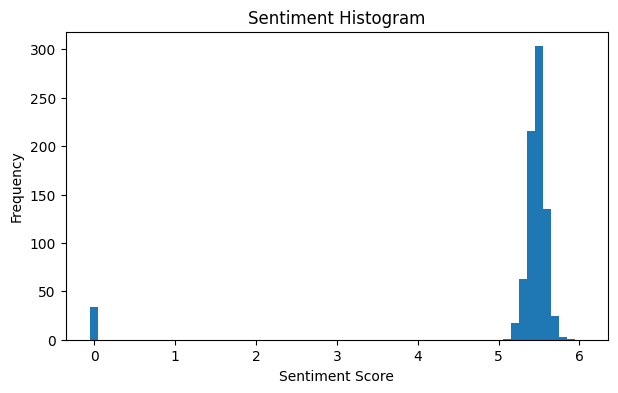

In [91]:
sentiments_list = list(sentiments.values())
max_s = max(sentiments_list)
min_s = min(sentiments_list)
v = np.arange(min_s, max_s + 0.2, 0.1)

s_counts, s_bins = np.histogram(sentiments_list, bins=v)

plt.figure(figsize=(7,4))
plt.bar(s_bins[:-1], s_counts, width=np.diff(s_bins))
plt.title("Sentiment Histogram")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()


> We see that a few rappers have sentiment 0. This is because they have no words in the happiness wordlist.

#### What are the 10 rappers with happiest and saddest pages?

In [92]:
for i, file_id in enumerate(sentiments):
    if file_id in west_file_list:
        coast = "West"
    else:
        coast = "East"
    if i == 0:
        print("Top 10")
    if i < 10:
        print(file_id, sentiments[file_id], coast)
    if i == 10:
        print("\nBottom 10")
    if i > len(sentiments)-11:
        print(file_id, sentiments[file_id], coast)

# remove all sentiments with 0
sentiments = {r: s for r, s in sentiments.items() if s != 0}
for i, file_id in enumerate(sentiments):
    if file_id in west_file_list:
        coast = "West"
    else:
        coast = "East"
    if i == 10:
        print("\nBottom 10 (non zero))")
    if i > len(sentiments)-11:
        print(file_id, sentiments[file_id], coast)


Top 10
DJ_Webstar.txt 5.918356164383562 East
Like_(record_producer).txt 5.808294930875573 East
Mark_Batson.txt 5.803961538461526 East
KC_Montero.txt 5.8011445783132505 West
Young_Music_DYMG.txt 5.786207951070336 East
Foreknown_(rapper).txt 5.777884615384617 West
Theo_Martins.txt 5.776470588235295 East
Emcee_N.I.C.E..txt 5.764515050167221 West
Sky_Blu_(rapper).txt 5.761993299832495 West
D_Smoke.txt 5.758519855595667 West

Bottom 10
RJ_(rapper).txt 0 West
Snupe.txt 0 West
Stressmatic.txt 0 West
Stunnaman.txt 0 West
T_Pup.txt 0 West
Tap_Dat_Ass.txt 0 West
V_White.txt 0 West
Vidal_Prevost.txt 0 West
Young_Dru.txt 0 West
Young_L.txt 0 West

Bottom 10 (non zero))
Jimmy_Wopo.txt 5.272624999999998 East
MC_Trouble.txt 5.265845588235292 West
AR_Ab.txt 5.2653738317756975 East
Bobby_Shmurda.txt 5.263807148794675 East
Cool_C.txt 5.2538976377952755 East
Killa_Sin.txt 5.248490566037733 East
Droop_E.txt 5.245639581657277 West
Hell_Rell.txt 5.232443438914029 East
Ol'_Dirty_Bastard.txt 5.21766476388167 

> The rappers with the happiest pages are:
>   1. DJ Webstar
>   2. Like (record_producer)
>   3. Mark Batson
>   4. KC Montero
>   5. Young Music DYMG
>   6. Foreknown (rapper)
>   7. Theo Martins
>   8. Emcee N.I.C.E.
>   9. Sky Blu (rapper)
>   10. D Smoke
>
> The rappers with the saddest pages are:
>   1. RJ (rapper)
>   2. Snupe
>   3. Stressmatic
>   4. Stunnaman
>   5. T Pup
>   6. Tap Dat_Ass
>   7. V White
>   8. Vidal Prevost
>   9. Young Dru
>   10. Young L
>
> however many more have the same sentiment of 0.
> If we disregard all the rappers with 0 sentiment the rappers with the saddest pages are:
>   1. Jimmy Wopo
>   2. MC Trouble
>   3. AR Ab
>   4. Bobby Shmurda
>   5. Cool C
>   6. Killa Sin
>   7. Droop E
>   8. Hell Rell
>   9. Ol' Dirty Bastard
>   10. Slip Capone


####  Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).

In [93]:
west_sentiment = 0
east_sentiment = 0
tot_sentiment = 0
num_west = 0
num_east = 0
num_tot = 0

for file_id in sentiments:
    num_tot += 1
    tot_sentiment += sentiments[file_id]
    if file_id in west_file_list:
        num_west += 1
        west_sentiment += sentiments[file_id]
    if file_id in east_file_list:
        num_east += 1
        east_sentiment += sentiments[file_id]

west_sentiment /= num_west
east_sentiment /= num_east
tot_sentiment /= num_tot

print(f'Average sentiment of the west coast: {west_sentiment}')
print(f'Average sentiment of the east coast: {east_sentiment}')
print(f'Average sentiment of all rappers: {tot_sentiment}')

Average sentiment of the west coast: 5.530002509092345
Average sentiment of the east coast: 5.518032783269289
Average sentiment of all rappers: 5.522956521277496


> According to the LabMT wordlist approach the East coast is the saddest coast as it has a lower sentiment than the West coast.

#### Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.

In [95]:
np.random.seed(42)
sentiments_values = list(sentiments.values())
count = 0
avg_random_sentiment = 0
for i in range(1000):
    np.random.shuffle(sentiments_values)
    random_sentiment = 0
    for j in range(num_west):
        random_sentiment += sentiments_values[j]
        
            
    random_sentiment /= num_west
    avg_random_sentiment += random_sentiment

    if random_sentiment < west_sentiment:
        count += 1

print(f'Fraction of randomly selected groups lower sentiment than the West coast: {count/1000}')
print(f'Average random sentiment: {avg_random_sentiment/1000}')

Fraction of randomly selected groups lower sentiment than the West coast: 0.95
Average random sentiment: 5.522829777803809


> 95% of the randomly selected groups of rappers of the same size as the West coast have a lower sentiment than the West coast. Thus with a 5% confidence bound the West coast is significantly happier than a randomly selected group of rappers of the same size.

#### Does the result make sense to you? Elaborate.

> The result does maybe seem a little strange since when looking at the top 10 happiest and saddest rappers, it does not seem like one coast is overrepresented in either of the lists. However, the top 10 and bottom 10 lists are nessesarily not representative of the whole coast.